In [35]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

In [2]:
import pandas as pd
from tensorflow import keras

In [3]:
from sklearn.manifold import TSNE
import os

In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

##### original_flattened_matrix & flattened_matrix

In [ ]:
def read_fasta(input_f):
    sequences = []
    current_seq = ""
    with open(input_f, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_seq:
                    sequences.append(current_seq)
                    current_seq = ""
            else:
                current_seq += line
        if current_seq:
            sequences.append(current_seq)
    return sequences

def select_random_sequences(sequences, num_samples=10000):
    if len(sequences) < num_samples :
        raise ValueError("The number of requested sequences exceeds the initial list size.")

    return random.sample(sequences, num_samples)


def encode_sequences_one_hot_with_gap(sequences, max_length=None) :

    amino_acids = '-ACDEFGHIKLMNPQRSTVWY'
    aa_to_idx = {aa: idx for idx, aa in enumerate(amino_acids)}
    valid_sequences = [seq for seq in sequences if all(aa in aa_to_idx for aa in seq)]

    if not valid_sequences :  # Return empty array if no valid sequences remain
        return np.array([])

    # Set maximum length
    if max_length is None :
        max_length = max(len(seq) for seq in valid_sequences)

    # Initialize the output matrix with zeros
    M = len(valid_sequences)
    L = max_length
    encoded_matrix = np.zeros((M, L, len(amino_acids)), dtype=np.float32)

    # Encode each sequence
    for i, seq in enumerate(valid_sequences) :
        for j, aa in enumerate(seq[:max_length]) :  # Truncate sequences longer than max_length
            encoded_matrix[i, j, aa_to_idx[aa]] = 1.0  # One-hot encode valid amino acids and gaps
    return encoded_matrix


In [6]:
seq_list = read_fasta('PF00069_noinserts_gaps_noduplicates.fasta')

In [7]:
small_batch_seq_list = select_random_sequences(seq_list, 200000)

In [8]:
encoded_matrix = encode_sequences_one_hot_with_gap(small_batch_seq_list, max_length=None)

In [9]:
M, L, A = encoded_matrix.shape  # M: number of sequences, L: sequence length, A: alphabet size (21)
flattened_matrix = encoded_matrix.reshape(M, L*A)  # Shape: (M, L * 21)
print(flattened_matrix.shape)

(199182, 5523)


In [ ]:
original_encoded_matrix = encode_sequences_one_hot_with_gap(seq_list)
M, L, A = original_encoded_matrix.shape
original_flattened_matrix = original_encoded_matrix.reshape(M, L*A)
print(original_flattened_matrix.shape)

In [5]:
# Save the flattened matrix in a compressed format
np.savez_compressed('original_flattened_matrix_compressed.npz', original_flattened_matrix)

##### loading the matrix

In [ ]:
loaded = np.load('original_flattened_matrix_compressed.npz')
original_flattened_matrix = loaded['arr_0']  # arr_0 is the default key if not explicitly named
print(original_flattened_matrix.shape)
print(original_flattened_matrix[2])
print(original_flattened_matrix[2])

#### vae model

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a sequence."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(layers.Layer):
    """Encodes sequences into latent space."""
    
    def __init__(self, latent_dim, intermediate_dims=[256, 128, 64], **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.dense_layers = []
        for dim in intermediate_dims:
            self.dense_layers.append(layers.Dense(dim, activation='relu'))
            self.dense_layers.append(layers.BatchNormalization())
            self.dense_layers.append(layers.Dropout(0.3))
        
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()
    
    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        
        return z_mean, z_log_var, z

class Decoder(layers.Layer):
    """Decodes a latent space point into a sequence."""
    
    def __init__(self, original_dim, intermediate_dims=[64, 128, 256], **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.dense_layers = []
        for dim in intermediate_dims:
            self.dense_layers.append(layers.Dense(dim, activation='relu'))
            self.dense_layers.append(layers.BatchNormalization())
            self.dense_layers.append(layers.Dropout(0.3))
        
        self.dense_output = layers.Dense(original_dim, activation='sigmoid')
    
    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        
        return self.dense_output(x)

class VAE(Model):
    """Variational Autoencoder for protein sequences."""
    
    def __init__(self, original_dim, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(original_dim)
        
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        # Add KL divergence regularization loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        
        # Scale KL loss by input dimension to balance it with reconstruction loss
        kl_loss = kl_loss * (1.0 / self.original_dim)
        
        self.add_loss(kl_loss)
        return reconstructed
    
    def encode(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return z_mean, z_log_var, z
    
    def decode(self, z):
        return self.decoder(z)
    
    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'original_dim': self.original_dim,
            'latent_dim': self.latent_dim
        })
        return config

-----

In [13]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(layers.Layer):
    """Encodes sequences into latent space."""
    def __init__(self, latent_dim, intermediate_dims=[256, 128, 64], **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.blocks = [
            self._make_dense_block(dim) 
            for dim in intermediate_dims
        ]
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def _make_dense_block(self, dim):
        return tf.keras.Sequential([
            layers.Dense(dim, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3)
        ])

    def call(self, inputs):
        x = inputs
        for block in self.blocks:
            x = block(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        return z_mean, z_log_var, z

class Decoder(layers.Layer):
    """Decodes latent space into sequences."""
    def __init__(self, original_dim, intermediate_dims=[64, 128, 256], **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.blocks = [
            self._make_dense_block(dim)
            for dim in intermediate_dims
        ]
        self.dense_output = layers.Dense(original_dim, activation='sigmoid')

    def _make_dense_block(self, dim):
        return tf.keras.Sequential([
            layers.Dense(dim, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3)
        ])

    def call(self, inputs):
        x = inputs
        for block in self.blocks:
            x = block(x)
        return self.dense_output(x)

In [ ]:
# Main execution code
if __name__ == "__main__":

    print(f"Origianl Flattened matrix shape: {flattened_matrix.shape}")
    
    # VAE parameters
    input_dim = flattened_matrix.shape[1]
    latent_dim = 32
    
    # Create and compile the VAE model
    vae = VAE(original_dim=input_dim, latent_dim=latent_dim)
    vae.compile(optimizer='adam', loss='binary_crossentropy')
    
    # Build the model with sample data to initialize weights
    dummy_input = np.zeros((1, input_dim), dtype=np.float32)
    _ = vae(dummy_input)
    
    # Print model summary
    vae.summary()
    
    # Split the data: 80% training, 20% validation
    X_train, X_val = train_test_split(flattened_matrix, test_size=0.2, random_state=42)
    
    # Convert to float32 to ensure compatibility
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=5,
        restore_best_weights=True
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_vae_model.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
    
    # Train the VAE model
    history = vae.fit(
        X_train, X_train,
        epochs=100,
        batch_size=128,
        validation_data=(X_val, X_val),
        callbacks=[early_stopping, model_checkpoint],
        shuffle=True
    )

Origianl Flattened matrix shape: (199157, 5523)


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │     1,461,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │     1,464,659 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,925,907 (11.16 MB)

 Trainable params: 2,924,115 (11.15 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1547
Epoch 1: val_loss improved from inf to 0.11458, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 60s 44ms/step - loss: 0.1547 - val_loss: 0.1146
Epoch 2/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1108
Epoch 2: val_loss improved from 0.11458 to 0.10213, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 77s 40ms/step - loss: 0.1108 - val_loss: 0.1021
Epoch 3/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0996
Epoch 3: val_loss improved from 0.10213 to 0.09473, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - loss: 0.0996 - val_loss: 0.0947
Epoch 4/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0931
Epoch 4: val_loss improved from 0.09473 to 0.09108, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - loss: 0.0931 - val_loss: 0.0911
Epoch 5/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0897
Epoch 5: val_loss improved from 0.09108 to 0.08904, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 48s 39ms/step - loss: 0.0897 - val_loss: 0.0890
Epoch 6/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0878
Epoch 6: val_loss improved from 0.08904 to 0.08776, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 48s 39ms/step - loss: 0.0878 - val_loss: 0.0878
Epoch 7/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0866
Epoch 7: val_loss improved from 0.08776 to 0.08688, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - loss: 0.0866 - val_loss: 0.0869
Epoch 8/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0857
Epoch 8: val_loss improved from 0.08688 to 0.08629, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - loss: 0.0857 - val_loss: 0.0863
Epoch 9/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0851
Epoch 9: val_loss improved from 0.08629 to 0.08585, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 0.0851 - val_loss: 0.0858
Epoch 10/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0846
Epoch 10: val_loss improved from 0.08585 to 0.08549, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - loss: 0.0846 - val_loss: 0.0855
Epoch 11/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0841
Epoch 11: val_loss improved from 0.08549 to 0.08527, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - loss: 0.0841 - val_loss: 0.0853
Epoch 12/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0838
Epoch 12: val_loss improved from 0.08527 to 0.08483, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - loss: 0.0838 - val_loss: 0.0848
Epoch 13/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0835
Epoch 13: val_loss improved from 0.08483 to 0.08473, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 0.0835 - val_loss: 0.0847
Epoch 14/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0832
Epoch 14: val_loss improved from 0.08473 to 0.08441, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 0.0832 - val_loss: 0.0844
Epoch 15/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0829
Epoch 15: val_loss improved from 0.08441 to 0.08425, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 0.0829 - val_loss: 0.0842
Epoch 16/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0827
Epoch 16: val_loss improved from 0.08425 to 0.08411, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 0.0827 - val_loss: 0.0841
Epoch 17/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0825
Epoch 17: val_loss improved from 0.08411 to 0.08394, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 0.0825 - val_loss: 0.0839
Epoch 18/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0823
Epoch 18: val_loss improved from 0.08394 to 0.08381, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 0.0823 - val_loss: 0.0838
Epoch 19/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0822
Epoch 19: val_loss did not improve from 0.08381
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - loss: 0.0822 - val_loss: 0.0839
Epoch 20/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0820
Epoch 20: val_loss improved from 0.08381 to 0.08363, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 0.0820 - val_loss: 0.0836
Epoch 21/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0819
Epoch 21: val_loss improved from 0.08363 to 0.08353, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - loss: 0.0819 - val_loss: 0.0835
Epoch 22/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0818
Epoch 22: val_loss improved from 0.08353 to 0.08335, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - loss: 0.0818 - val_loss: 0.0834
Epoch 23/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0816
Epoch 23: val_loss improved from 0.08335 to 0.08321, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 48s 39ms/step - loss: 0.0816 - val_loss: 0.0832
Epoch 24/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0815
Epoch 24: val_loss improved from 0.08321 to 0.08320, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - loss: 0.0815 - val_loss: 0.0832
Epoch 25/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0814
Epoch 25: val_loss improved from 0.08320 to 0.08319, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - loss: 0.0814 - val_loss: 0.0832
Epoch 26/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0813
Epoch 26: val_loss improved from 0.08319 to 0.08302, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - loss: 0.0813 - val_loss: 0.0830
Epoch 27/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0812
Epoch 27: val_loss improved from 0.08302 to 0.08299, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 80s 44ms/step - loss: 0.0812 - val_loss: 0.0830
Epoch 28/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0811
Epoch 28: val_loss improved from 0.08299 to 0.08292, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - loss: 0.0811 - val_loss: 0.0829
Epoch 29/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0810
Epoch 29: val_loss improved from 0.08292 to 0.08284, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - loss: 0.0810 - val_loss: 0.0828
Epoch 30/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0809
Epoch 30: val_loss improved from 0.08284 to 0.08278, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - loss: 0.0809 - val_loss: 0.0828
Epoch 31/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0808
Epoch 31: val_loss did not improve from 0.08278
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - loss: 0.0808 - val_loss: 0.0828
Epoch 32/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0808
Epoch 32: val_loss improved from 0.08278 to 0.08271, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - loss: 0.0808 - val_loss: 0.0827
Epoch 33/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0807
Epoch 33: val_loss improved from 0.08271 to 0.08266, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - loss: 0.0807 - val_loss: 0.0827
Epoch 34/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0806
Epoch 34: val_loss improved from 0.08266 to 0.08262, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - loss: 0.0806 - val_loss: 0.0826
Epoch 35/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0806
Epoch 35: val_loss improved from 0.08262 to 0.08252, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - loss: 0.0806 - val_loss: 0.0825
Epoch 36/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0805
Epoch 36: val_loss did not improve from 0.08252
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - loss: 0.0805 - val_loss: 0.0825
Epoch 37/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0804
Epoch 37: val_loss did not improve from 0.08252
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - loss: 0.0804 - val_loss: 0.0825
Epoch 38/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0804
Epoch 38: val_loss improved from 0.08252 to 0.08251, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - loss: 0.0804 - val_loss: 0.0825
Epoch 39/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0803
Epoch 39: val_loss did not improve from 0.08251
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - loss: 0.0803 - val_loss: 0.0825
Epoch 40/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0803
Epoch 40: val_loss improved from 0.08251 to 0.08247, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - loss: 0.0803 - val_loss: 0.0825
Epoch 41/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0802
Epoch 41: val_loss improved from 0.08247 to 0.08235, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 80s 43ms/step - loss: 0.0802 - val_loss: 0.0823
Epoch 42/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0801
Epoch 42: val_loss improved from 0.08235 to 0.08225, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - loss: 0.0801 - val_loss: 0.0822
Epoch 43/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0801
Epoch 43: val_loss improved from 0.08225 to 0.08223, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - loss: 0.0801 - val_loss: 0.0822
Epoch 44/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0800
Epoch 44: val_loss did not improve from 0.08223
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - loss: 0.0800 - val_loss: 0.0822
Epoch 45/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0800
Epoch 45: val_loss improved from 0.08223 to 0.08219, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - loss: 0.0800 - val_loss: 0.0822
Epoch 46/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0800
Epoch 46: val_loss improved from 0.08219 to 0.08217, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - loss: 0.0800 - val_loss: 0.0822
Epoch 47/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0799
Epoch 47: val_loss improved from 0.08217 to 0.08212, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - loss: 0.0799 - val_loss: 0.0821
Epoch 48/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0799
Epoch 48: val_loss improved from 0.08212 to 0.08207, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - loss: 0.0799 - val_loss: 0.0821
Epoch 49/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0798
Epoch 49: val_loss improved from 0.08207 to 0.08205, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - loss: 0.0798 - val_loss: 0.0821
Epoch 50/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0798
Epoch 50: val_loss did not improve from 0.08205
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - loss: 0.0798 - val_loss: 0.0821
Epoch 51/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0797
Epoch 51: val_loss did not improve from 0.08205
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - loss: 0.0797 - val_loss: 0.0821
Epoch 52/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0797
Epoch 52: val_loss improved from 0.08205 to 0.08198, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - loss: 0.0797 - val_loss: 0.0820
Epoch 53/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0797
Epoch 53: val_loss improved from 0.08198 to 0.08196, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 80s 46ms/step - loss: 0.0797 - val_loss: 0.0820
Epoch 54/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0796
Epoch 54: val_loss improved from 0.08196 to 0.08193, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - loss: 0.0796 - val_loss: 0.0819
Epoch 55/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0796
Epoch 55: val_loss did not improve from 0.08193
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - loss: 0.0796 - val_loss: 0.0820
Epoch 56/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0796
Epoch 56: val_loss improved from 0.08193 to 0.08190, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - loss: 0.0796 - val_loss: 0.0819
Epoch 57/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0795
Epoch 57: val_loss improved from 0.08190 to 0.08188, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - loss: 0.0795 - val_loss: 0.0819
Epoch 58/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0795
Epoch 58: val_loss improved from 0.08188 to 0.08186, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - loss: 0.0795 - val_loss: 0.0819
Epoch 59/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0795
Epoch 59: val_loss did not improve from 0.08186
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - loss: 0.0795 - val_loss: 0.0819
Epoch 60/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0794
Epoch 60: val_loss improved from 0.08186 to 0.08183, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - loss: 0.0794 - val_loss: 0.0818
Epoch 61/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0794
Epoch 61: val_loss improved from 0.08183 to 0.08180, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - loss: 0.0794 - val_loss: 0.0818
Epoch 62/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0794
Epoch 62: val_loss did not improve from 0.08180
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - loss: 0.0794 - val_loss: 0.0818
Epoch 63/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0794
Epoch 63: val_loss improved from 0.08180 to 0.08174, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - loss: 0.0794 - val_loss: 0.0817
Epoch 64/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0793
Epoch 64: val_loss did not improve from 0.08174
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - loss: 0.0793 - val_loss: 0.0818
Epoch 65/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0793
Epoch 65: val_loss improved from 0.08174 to 0.08172, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - loss: 0.0793 - val_loss: 0.0817
Epoch 66/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0793
Epoch 66: val_loss did not improve from 0.08172
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - loss: 0.0793 - val_loss: 0.0817
Epoch 67/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0792
Epoch 67: val_loss improved from 0.08172 to 0.08165, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - loss: 0.0792 - val_loss: 0.0817
Epoch 68/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0792
Epoch 68: val_loss did not improve from 0.08165
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 0.0792 - val_loss: 0.0817
Epoch 69/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0792
Epoch 69: val_loss did not improve from 0.08165
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - loss: 0.0792 - val_loss: 0.0817
Epoch 70/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0792
Epoch 70: val_loss improved from 0.08165 to 0.08163, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 0.0792 - val_loss: 0.0816
Epoch 71/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0791
Epoch 71: val_loss did not improve from 0.08163
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 84s 41ms/step - loss: 0.0791 - val_loss: 0.0816
Epoch 72/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0791
Epoch 72: val_loss improved from 0.08163 to 0.08161, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - loss: 0.0791 - val_loss: 0.0816
Epoch 73/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0791
Epoch 73: val_loss did not improve from 0.08161
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - loss: 0.0791 - val_loss: 0.0816
Epoch 74/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0791
Epoch 74: val_loss did not improve from 0.08161
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - loss: 0.0791 - val_loss: 0.0816
Epoch 75/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0790
Epoch 75: val_loss did not improve from 0.08161
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - loss: 0.0790 - val_loss: 0.0816
Epoch 76/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0790
Epoch 76: val_loss did not improve from 0.08161
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 48s 39ms/step - loss: 0.0790 - val_loss: 0.0817
Epoch 77/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0790
Epoch 77: val_loss improved from 0.08161 to 0.08155, 

1245/1245 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - loss: 0.0790 - val_loss: 0.0816
Epoch 78/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0790
Epoch 78: val_loss improved from 0.08155 to 0.08153, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 0.0790 - val_loss: 0.0815
Epoch 79/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0790
Epoch 79: val_loss did not improve from 0.08153
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 48s 39ms/step - loss: 0.0790 - val_loss: 0.0816
Epoch 80/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0789
Epoch 80: val_loss improved from 0.08153 to 0.08151, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - loss: 0.0789 - val_loss: 0.0815
Epoch 81/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0789
Epoch 81: val_loss improved from 0.08151 to 0.08147, saving model to best_vae_model.h5


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - loss: 0.0789 - val_loss: 0.0815
Epoch 82/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0789
Epoch 82: val_loss did not improve from 0.08147
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - loss: 0.0789 - val_loss: 0.0816
Epoch 83/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0789
Epoch 83: val_loss did not improve from 0.08147
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - loss: 0.0789 - val_loss: 0.0815
Epoch 84/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0789
Epoch 84: val_loss did not improve from 0.08147
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - loss: 0.0789 - val_loss: 0.0815
Epoch 85/100
1244/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0788
Epoch 85: val_loss did not improve from 0.08147
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - loss: 0.0788 - val_loss: 0.0815
Epoch 86/100
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0788
Epoch 86: val_loss did not improve from 0.08147
1245/

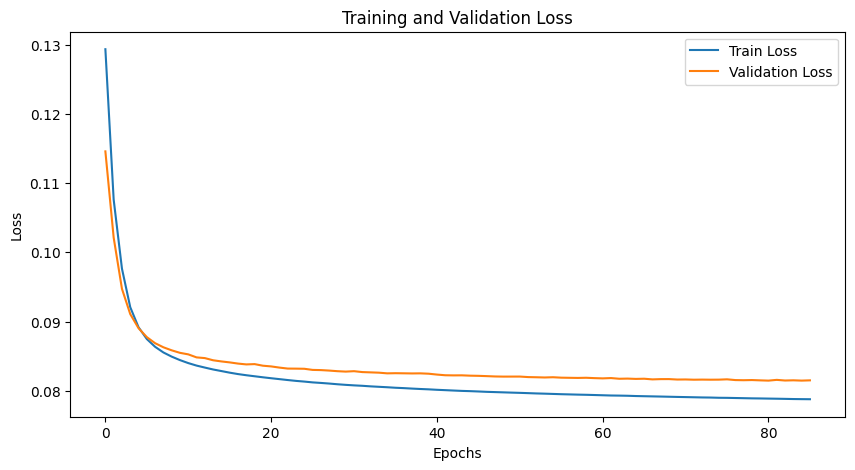

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

### Loading the model

In [18]:
# Regenerate the split 
X_train, X_val = train_test_split(
    flattened_matrix, 
    test_size=0.2, 
    random_state=42  # Critical for same split
)
X_val = X_val.astype(np.float32)

In [19]:
from tensorflow.keras.models import load_model

# original dimension
original_dim = X_val.shape[1]  
latent_dim = 32

# Define custom objects with UPDATED classes
custom_objects = {
    'Sampling': Sampling,
    'Encoder': Encoder,
    'Decoder': Decoder,
    'VAE': VAE
}

# 1. First build the model architecture
def build_vae_model():
    vae = VAE(original_dim=original_dim, latent_dim=latent_dim)
    
    # Build with dummy input
    dummy_input = np.zeros((1, original_dim), dtype=np.float32)
    _ = vae(dummy_input)
    return vae

# 2. Create model instance
vae = build_vae_model()

# 3. Load weights using explicit weight loading
try:
    vae.load_weights('200000seq_best_vae_model.h5')
    print("Weights loaded successfully!")
except Exception as e:
    print(f"Loading error: {str(e)}")
    print("\nCommon fixes:")
    print("1. Verify original_dim matches training input dimension")
    print("2. Ensure TensorFlow versions match (2.x during both save/load)")
    print("3. Check if model was saved with save() vs save_weights()")

Weights loaded successfully!


In [51]:
# Test encoding
sample_input = X_val[:1]  # Use actual validation data shape
z_mean, z_log_var, z = vae.encode(sample_input)
print("Encoded latent sample:", z.numpy()[0][:5])

# Test reconstruction
a = 0
for i in range(100):

    reconstructed = vae.decode(z)
    print("Reconstruction error:", np.mean((sample_input - reconstructed.numpy())**2))
    a += np.mean((sample_input - reconstructed.numpy())**2)

print(a/10)

Encoded latent sample: [-0.5736701   0.02891688 -0.6675908  -1.2774761   0.09245875]
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.032601044
Reconstruction error: 0.0326010

#### Compare Input and Reconstructed Sequences

##### Heatmap

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


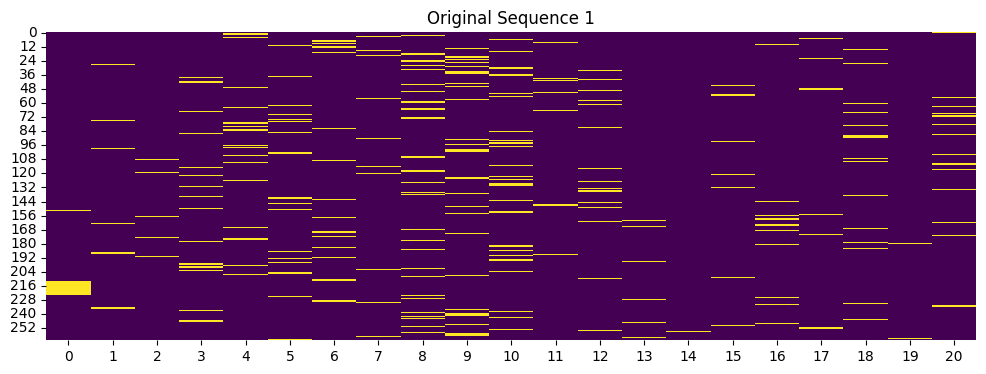

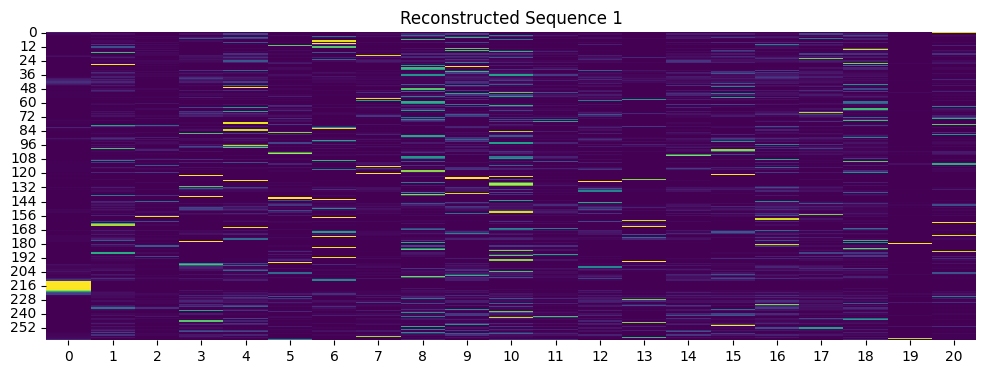

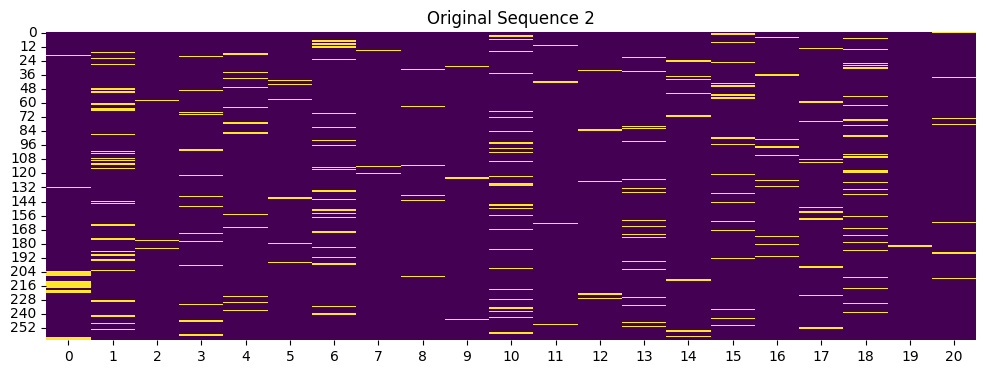

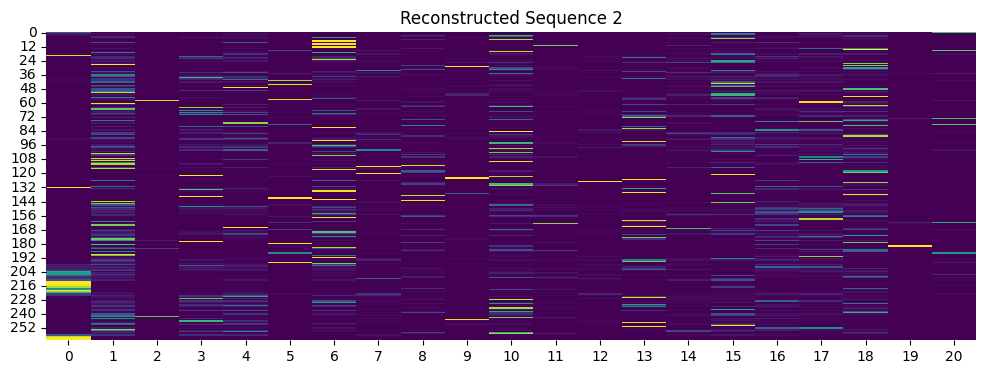

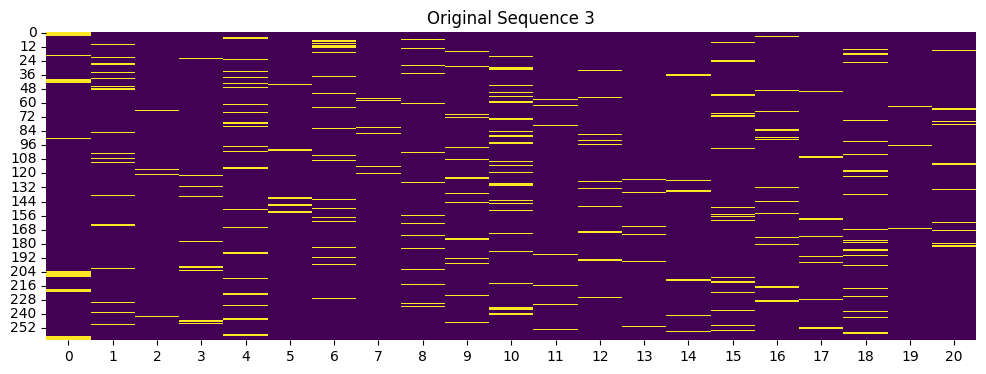

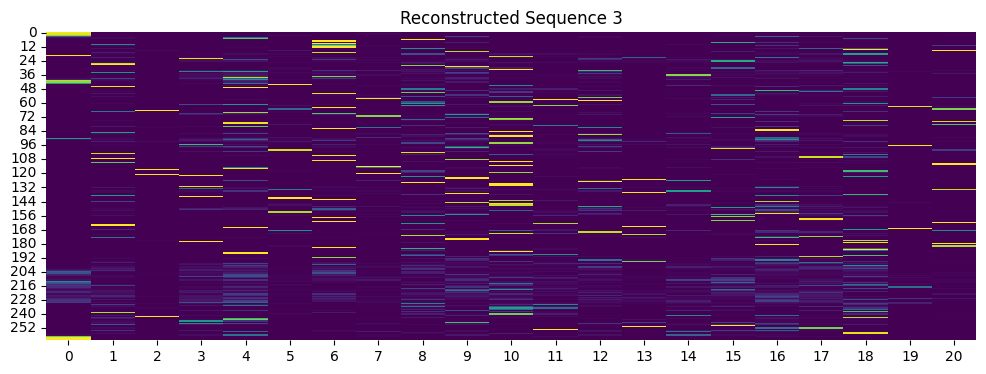

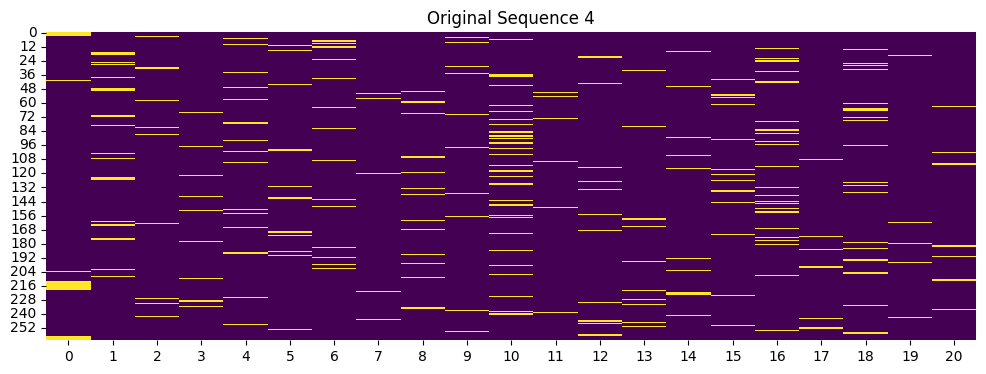

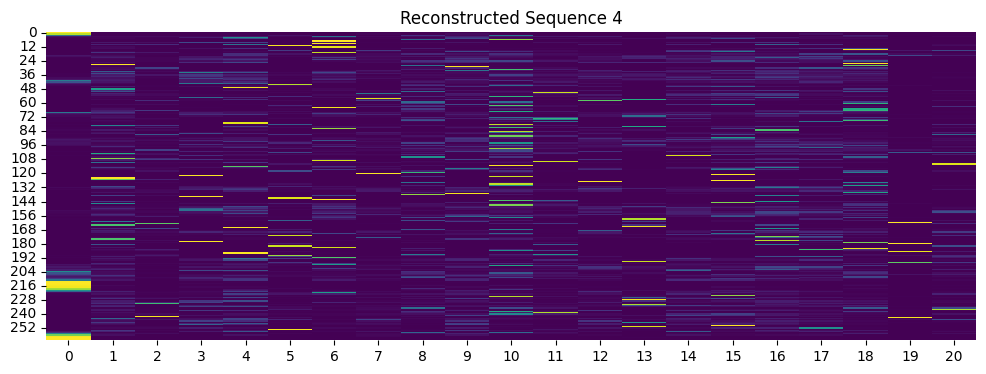

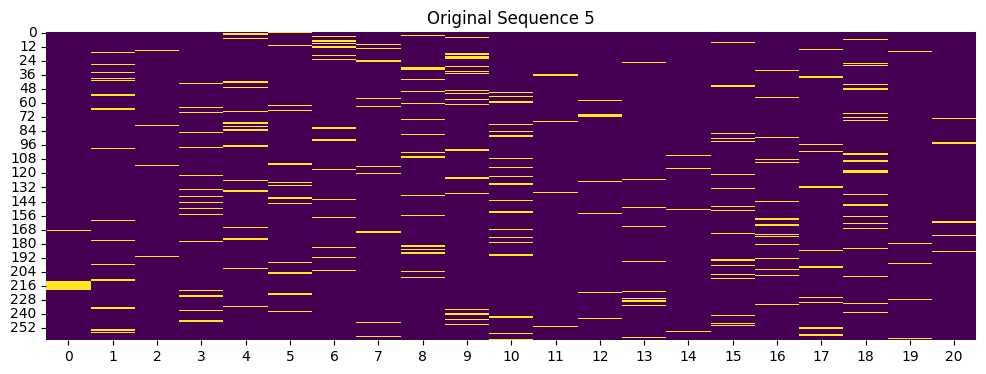

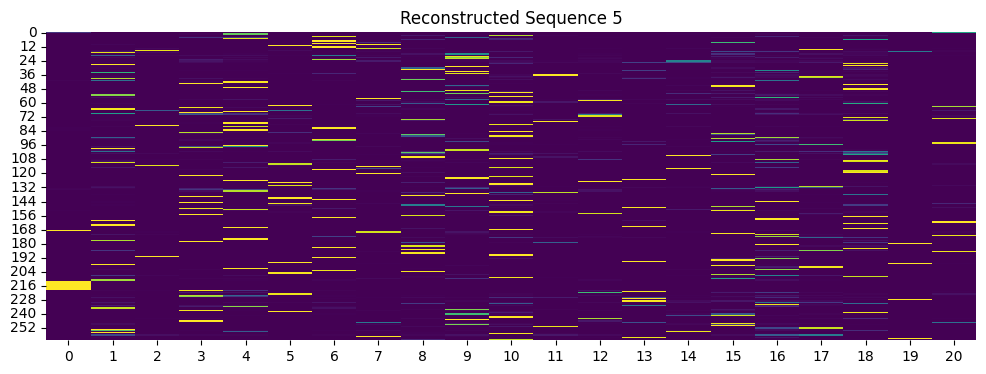

In [ ]:
# Get a few example sequences from X_val
n_examples = 5
examples = X_val[:n_examples]
reconstructions = vae.predict(examples)

import seaborn as sns

for i in range(n_examples):
    plt.figure(figsize=(12, 4))
    sns.heatmap(np.reshape(examples[i], (L, -1)), cmap="viridis", cbar=False)
    plt.title(f"Original Sequence {i+1}")
    plt.show()

    plt.figure(figsize=(12, 4))
    sns.heatmap(np.reshape(reconstructions[i], (L, -1)), cmap="viridis", cbar=False)
    plt.title(f"Reconstructed Sequence {i+1}")
    plt.show()

##### Binary Accuracy

In [23]:
# Threshold reconstructed outputs to binary values
recon_binary = (reconstructions > 0.5).astype(np.float32)

# Compute element-wise accuracy for each sample
accuracies = np.mean((X_val[:n_examples] == recon_binary[:n_examples]), axis=1)

# Average accuracy over samples
avg_accuracy = np.mean(accuracies)
print("Average Reconstruction Accuracy:", avg_accuracy)


Average Reconstruction Accuracy: 0.9765707043273583


##### Levenshtein Distance

In [50]:
import Levenshtein

def one_hot_to_sequence(one_hot, alphabet='-ACDEFGHIKLMNPQRSTVWY'):
    # one_hot: shape (L, 21)
    # choose the amino acid corresponding to the maximum value in each position
    indices = np.argmax(one_hot, axis=-1)
    return ''.join([alphabet[idx] for idx in indices])

original_seq = one_hot_to_sequence(np.reshape(X_val[0], (L, -1)))
reconstructed_seq = one_hot_to_sequence(np.reshape(reconstructions[0], (L, -1)))
print(original_seq)
print(reconstructed_seq)
edit_distance = Levenshtein.distance(original_seq, reconstructed_seq)
print("Levenshtein distance for sample sequence:", edit_distance)


YEIHETLGMGSFGKVHLGIHKKTKIKVAIKLINKKKLFDMNMDKIRKETNIMLRLYHKNIVNFYEIMDVYFYIIFAFEYVENGELFDYVVHKLRLKELEAKKFFYEIVCGVEYLHDNYICHRDLKLENILLDRNYNIKIVDFGLSNFMKNDF-LKTSCGSPNYASPEVISGKTYGCEIDVWSLGVILFAMLCGFLPFDDEDIHDLFEKIRNG------------IFSIPGHVSYYAKDLIKKILIVDPSKRITLNQIKKHPWF
YTLGKTIGEGSFGKVKLATHKLTGEKVAIKIIEKKRLSSDNLERVKREIKILKLLRHPHIIKLYEVIETDKKIYIVMEYASGGELFDYIVRKGRLSEEEARRFFQQILSGVEYLHSQGIVHRDLKPENLLLDSDLNIKIADFGLSNTYKDGNFLKTSCGSPCYAAPELISGKPYGPEVDIWSCGVILYAMLCGYLPFDDENVEELFRKIIRG------------SYEIPSHLSPEAKDLIRRMLVVDPKKRITIKDILQHPWF
Levenshtein distance for sample sequence: 109


##### Average cosine similarity

In [52]:
z_mean_orig, _, _ = vae.encode(X_val[:n_examples])
z_mean_recon, _, _ = vae.encode(reconstructions[:n_examples])

# Compute cosine similarity or Euclidean distance between original and re-encoded latent vectors
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(z_mean_orig.numpy(), z_mean_recon.numpy())
print("Average cosine similarity between original and reconstructed latent vectors:",
      np.mean(np.diag(cosine_sim)))

Average cosine similarity between original and reconstructed latent vectors: 0.98879147


#### Pca Tsne on unlabled data on latent space

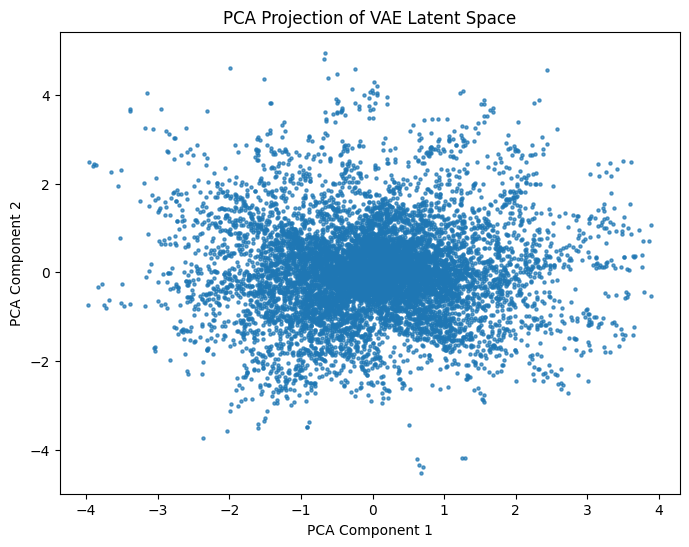

In [53]:
# Select a subset of the validation set (for example, 5000 samples)
subset = X_val[:10000]

# Use the VAE encoder to obtain latent representations (z_mean)
z_mean, _, _ = vae.encode(subset)

# Convert the tensor to a NumPy array (if necessary)
z_mean_np = z_mean.numpy() if hasattr(z_mean, 'numpy') else z_mean

# Apply PCA to reduce the latent dimensionality to 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(z_mean_np)

# Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=5, alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of VAE Latent Space")
plt.show()


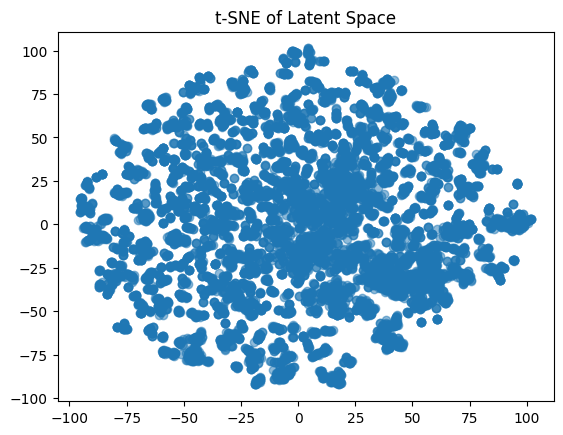

In [ ]:
z_mean, _, _ = vae.encoder(X_val[:10000])
tsne = TSNE(n_components=2).fit_transform(z_mean)

plt.scatter(tsne[:,0], tsne[:,1], alpha=0.5)
plt.title('t-SNE of Latent Space');

#### elbow & silouhette

Clustering Progress: 100%|██████████| 20/20 [10:56<00:00, 32.85s/it]


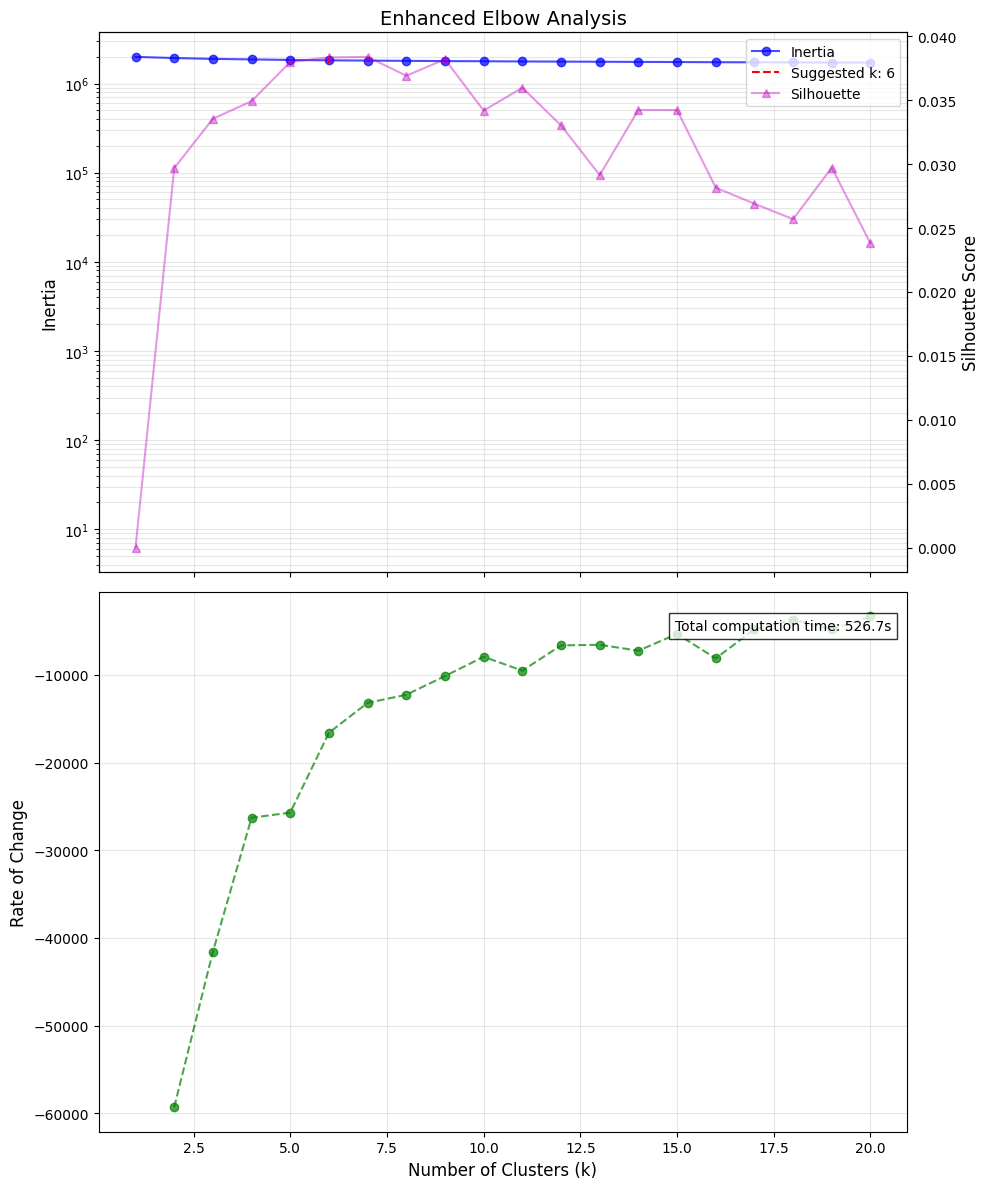

In [58]:
from tqdm import tqdm
from kneed import KneeLocator
import time
def elbow_analysis(data, max_k=20, use_minibatch=False, random_state=42):

    if not isinstance(data, np.ndarray):
        data = np.array(data)
        
    # Standardization warning
    if not (np.allclose(data.mean(axis=0), 0, atol=1e-2) and 
        np.allclose(data.std(axis=0), 1, atol=1e-2)):
        print("Warning: Data appears unstandardized. Consider using StandardScaler first.")
    
    # Sanity check for maximum k
    max_k = min(max_k, data.shape[0]//2)  # Prevent more clusters than half the samples
    
    ks = range(1, max_k+1)
    metrics = {
        'inertias': [],
        'silhouettes': [],
        'times': []
    }
    
    # Choose appropriate KMeans variant
    kmeans_class = MiniBatchKMeans if use_minibatch else KMeans
    
    for k in tqdm(ks, desc="Clustering Progress"):
        if k == 1:  # Special case for single cluster
            metrics['inertias'].append(np.sum((data - data.mean(axis=0))**2))
            metrics['silhouettes'].append(0)
            continue
            
        model = kmeans_class(n_clusters=k, 
                            random_state=random_state,
                            n_init='auto' if use_minibatch else 10)
        
        start_time = time.time()
        model.fit(data)
        metrics['times'].append(time.time() - start_time)
        
        metrics['inertias'].append(model.inertia_)
        
        # Silhouette score for k > 1
        if k > 1:
            metrics['silhouettes'].append(silhouette_score(data, model.labels_))
        else:
            metrics['silhouettes'].append(0)
    
    # Calculate derivatives for elbow detection
    derivatives = np.diff(metrics['inertias'])
    metrics['derivatives'] = derivatives
    
    # Automated elbow detection
    kneedle = KneeLocator(ks, metrics['inertias'], curve='convex', direction='decreasing')
    elbow_k = kneedle.elbow
    
    # Create enhanced visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
    
    # Inertia plot
    ax1.plot(ks, metrics['inertias'], 'bo-', alpha=0.7, label='Inertia')
    ax1.set_ylabel('Inertia', fontsize=12)
    ax1.set_yscale('log')  # Handle large inertia ranges
    ax1.grid(True, which='both', alpha=0.3)
    ax1.set_title('Enhanced Elbow Analysis', fontsize=14)
    
    # Mark detected elbow point
    if elbow_k is not None:
        ax1.vlines(elbow_k, *ax1.get_ylim(), colors='r', linestyles='--',
                  label=f'Suggested k: {elbow_k}')
    
    # Derivative plot
    ax2.plot(ks[1:], derivatives, 'go--', alpha=0.7, label='1st Derivative')
    ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax2.set_ylabel('Rate of Change', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Silhouette scores
    ax1b = ax1.twinx()
    ax1b.plot(ks, metrics['silhouettes'], 'm^-', alpha=0.4, label='Silhouette')
    ax1b.set_ylabel('Silhouette Score', fontsize=12)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1b.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Timing information
    ax2.text(0.98, 0.95, f"Total computation time: {sum(metrics['times']):.1f}s",
            transform=ax2.transAxes, ha='right', va='top',
            bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    return {
        'metrics': metrics,
        'elbow_k': elbow_k,
        'figure': fig,
        'axes': (ax1, ax2)
    }
results = elbow_analysis(X_val[:10000], max_k=20)
plt.show()

#### Kmeans

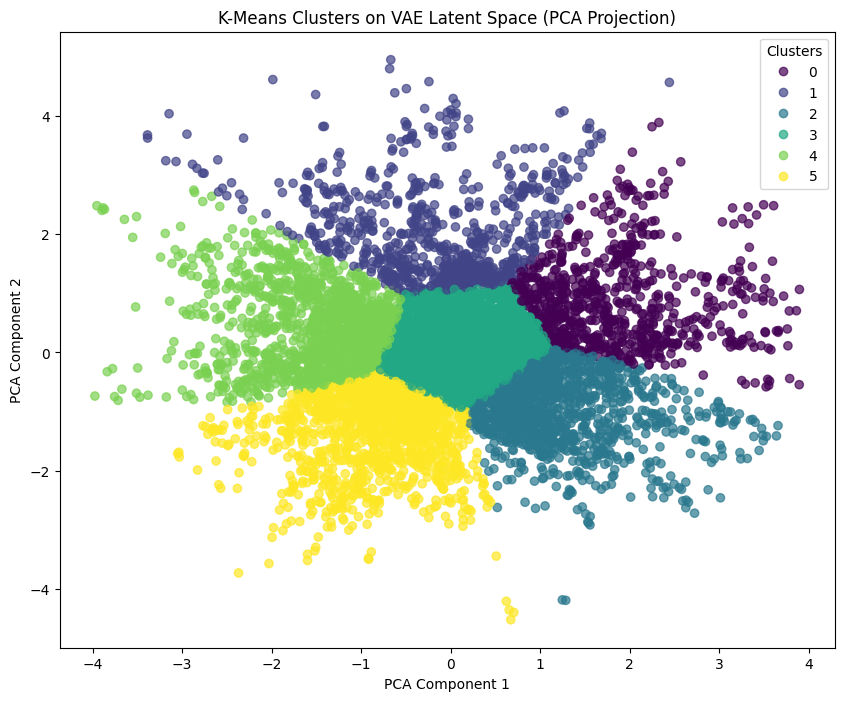

In [ ]:

subset = X_val[:10000]

# Obtain the latent representations (z_mean) using the VAE encoder.
z_mean, _, _ = vae.encode(subset)
# Convert to a NumPy array if necessary
z_mean_np = z_mean.numpy() if hasattr(z_mean, 'numpy') else z_mean

# Apply PCA to reduce the latent representations to 2 dimensions.
pca = PCA(n_components=2)
pca_result = pca.fit_transform(z_mean_np)

# Perform K-Means clustering with 6 clusters on the PCA-transformed data.
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(pca_result)

# Plot the PCA results with clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clusters on VAE Latent Space (PCA Projection)")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


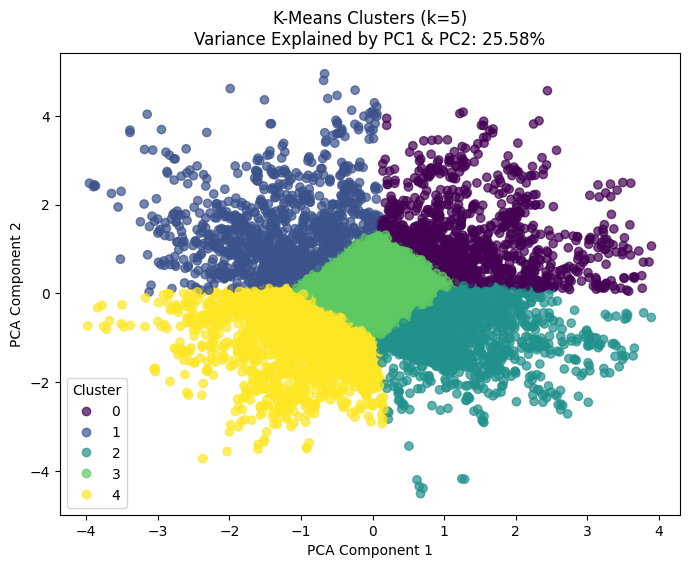

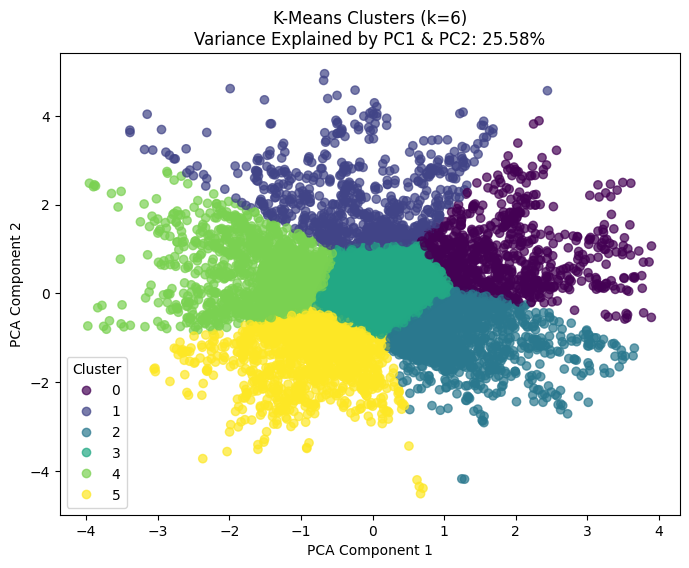

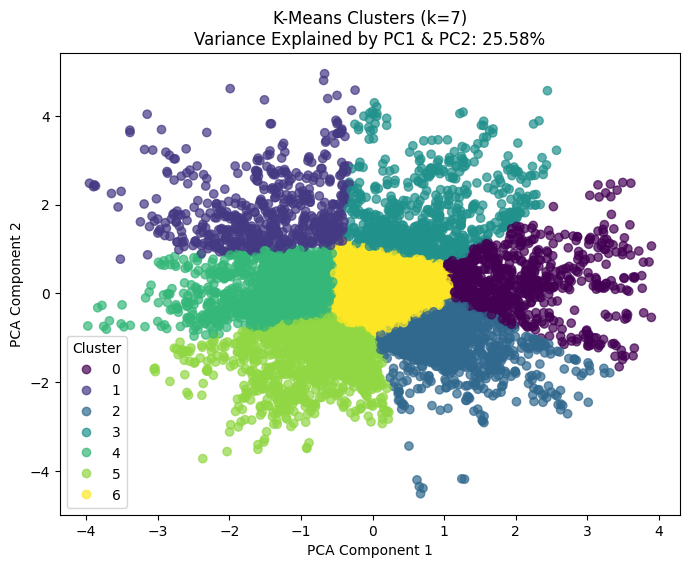

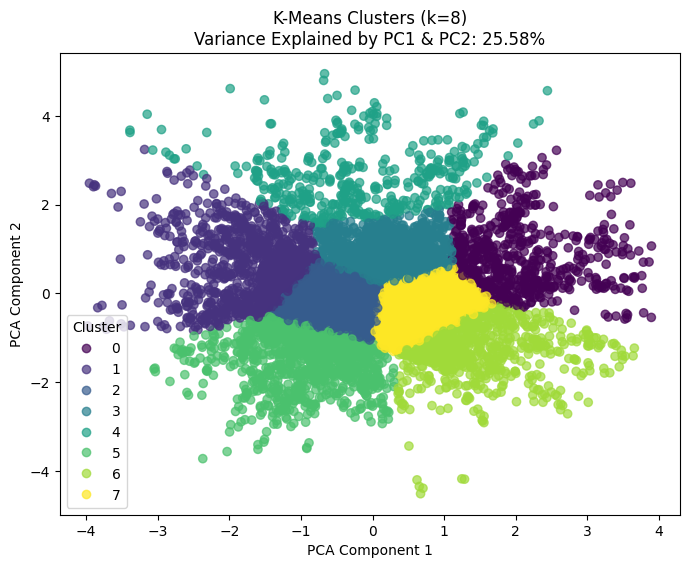

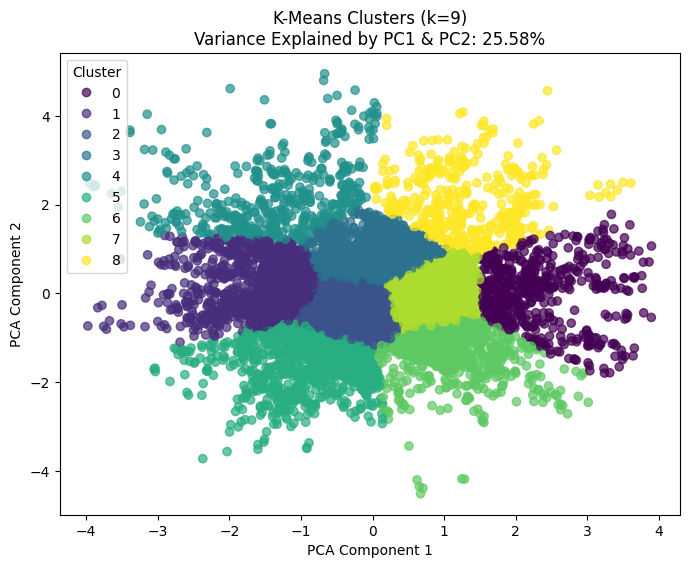

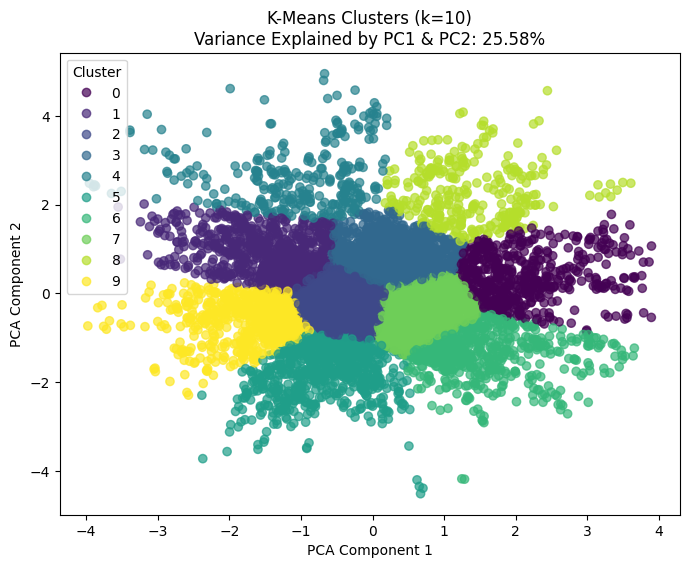

In [73]:

subset = X_val[:10000]

# Extract latent representations using the VAE encoder.
z_mean, _, _ = vae.encode(subset)
z_mean_np = z_mean.numpy() if hasattr(z_mean, 'numpy') else z_mean

# Apply PCA to reduce the latent representations to 2 dimensions.
pca = PCA(n_components=2)
pca_result = pca.fit_transform(z_mean_np)

# Calculate variance explained by the first two principal components
variance_explained = np.sum(pca.explained_variance_ratio_) * 100  # in percentage

# Loop over different numbers of clusters: 6 to 10
for k in range(5, 11):
    # K-Means clustering with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(pca_result)
    
    # Create scatter plot with clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.7)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"K-Means Clusters (k={k})\nVariance Explained by PC1 & PC2: {variance_explained:.2f}%")
    plt.legend(*scatter.legend_elements(), title="Cluster")
    plt.show()


##### Labeled data

In [24]:
top_5_kinase_data = {}

# fasta_dir = "D:\info\BIM-s2\prj bim\main\hmm"
fasta_dir = "D:\info\BIM-s2\prj bim\main\hmm"

# Iterate through files in the current directory
for filename in os.listdir(fasta_dir):
    if filename.endswith(".fasta"):
        kinase_type = filename[:-6]  # Remove ".fasta" extension
        filepath = os.path.join(fasta_dir, filename)

        # Read, encode, and flatten in one go
        sequences = read_fasta(filepath)
        encoded_matrix = encode_sequences_one_hot_with_gap(sequences)
        M, L, A = encoded_matrix.shape
        flattened_matrix = encoded_matrix.reshape(M, L * A)

        # Store only the flattened matrix
        top_5_kinase_data[kinase_type] = flattened_matrix  

        print(f"Number of {kinase_type} sequences: {M}")  # M is the number of sequences
        print(f"Length of a {kinase_type} sequence: {len(sequences[0])}\n")

Number of casein_kinases_noInserts_noGaps_noDuplicates sequences: 31
Length of a casein_kinases_noInserts_noGaps_noDuplicates sequence: 263

Number of cyclin_dependent_kinases_noInserts_noGaps_noDuplicates sequences: 172
Length of a cyclin_dependent_kinases_noInserts_noGaps_noDuplicates sequence: 263

Number of mitogen_activated_kinases_noInserts_noGaps_noDuplicates sequences: 176
Length of a mitogen_activated_kinases_noInserts_noGaps_noDuplicates sequence: 263

Number of serine_threonine_kinases_noInserts_noGaps_noDuplicates sequences: 1121
Length of a serine_threonine_kinases_noInserts_noGaps_noDuplicates sequence: 263

Number of tyrosine_kinases_noInserts_noGaps_noDuplicates sequences: 28
Length of a tyrosine_kinases_noInserts_noGaps_noDuplicates sequence: 263



In [25]:
top_15_kinase_data = {}

# fasta_dir = "D:\info\BIM-s2\prj bim\main\hmm"
fasta_dir = "D:\info\BIM-s2\prj bim\main\hmm_20"

# Iterate through files in the current directory
for filename in os.listdir(fasta_dir):
    if filename.endswith(".fasta"):
        kinase_type = filename[:-6]  # Remove ".fasta" extension
        filepath = os.path.join(fasta_dir, filename)

        # Read, encode, and flatten in one go
        sequences = read_fasta(filepath)
        encoded_matrix = encode_sequences_one_hot_with_gap(sequences)
        M, L, A = encoded_matrix.shape
        flattened_matrix = encoded_matrix.reshape(M, L * A)

        # Store only the flattened matrix
        top_15_kinase_data[kinase_type] = flattened_matrix  

        print(f"Number of {kinase_type} sequences: {M}")  # M is the number of sequences
        print(f"Length of a {kinase_type} sequence: {len(sequences[0])}\n")

Number of aurora_kinases_noInserts_noGaps_noDuplicates sequences: 32
Length of a aurora_kinases_noInserts_noGaps_noDuplicates sequence: 263

Number of calcium_calmodulin_dependent_kinases_noInserts_noGaps_noDuplicates sequences: 32
Length of a calcium_calmodulin_dependent_kinases_noInserts_noGaps_noDuplicates sequence: 263

Number of calcium_dependent_kinases_noInserts_noGaps_noDuplicates sequences: 80
Length of a calcium_dependent_kinases_noInserts_noGaps_noDuplicates sequence: 263

Number of cAMP_dependent_protein_kinases_noInserts_noGaps_noDuplicates sequences: 27
Length of a cAMP_dependent_protein_kinases_noInserts_noGaps_noDuplicates sequence: 263

Number of casein_kinases_noInserts_noGaps_noDuplicates sequences: 31
Length of a casein_kinases_noInserts_noGaps_noDuplicates sequence: 263

Number of CBL_interacting_protein_kinases_noInserts_noGaps_noDuplicates sequences: 31
Length of a CBL_interacting_protein_kinases_noInserts_noGaps_noDuplicates sequence: 263

Number of cyclin_depen

#### Extract Latent Representations from Labeled Data

##### top 5 kinases

In [ ]:
# Prepare lists to collect latent representations and their labels.
labeled_latents = []
labeled_labels = []

# Iterate through each kinase type in your dictionary.
for kinase_type, matrix in top_5_kinase_data.items():
    # Convert data to float32 if necessary.
    matrix = matrix.astype(np.float32)
    
    # Pass the flattened matrix through the encoder.
    z_mean, _, _ = vae.encode(matrix)
    # Convert to a NumPy array (if the output is a tensor)
    z_mean_np = z_mean.numpy() if hasattr(z_mean, 'numpy') else z_mean

    # Append the latent representations and label repeated for each sample.
    labeled_latents.append(z_mean_np)
    labeled_labels.extend([kinase_type] * z_mean_np.shape[0])

# Concatenate latent vectors of all kinase types into a single array.
labeled_latents = np.concatenate(labeled_latents, axis=0)

##### Latent representation for unlabeled data

In [67]:
latent_unlabeled, _, _ = vae.encode(X_val[:10000])  # shape: (10000, latent_dim)
latent_unlabeled = latent_unlabeled.numpy()

##### pca on labeled latents

Variance explained by the top 2 PCA components: 35.46%


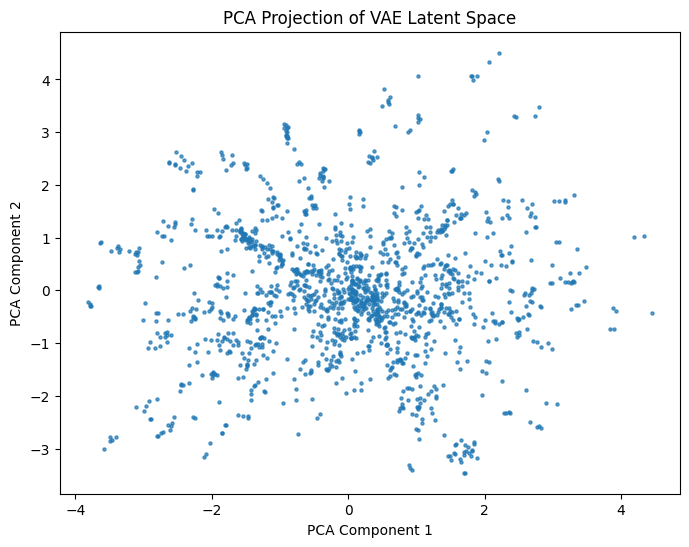

In [71]:
# Apply PCA to reduce the latent space to 2 dimensions.
pca = PCA(n_components=2)
labeled_pca = pca.fit_transform(labeled_latents)

# Calculate the variance explained by the top 2 components.
variance_explained = np.sum(pca.explained_variance_ratio_) * 100
print(f"Variance explained by the top 2 PCA components: {variance_explained:.2f}%")

# Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(labeled_pca[:, 0], labeled_pca[:, 1], s=5, alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of VAE Latent Space")
plt.show()



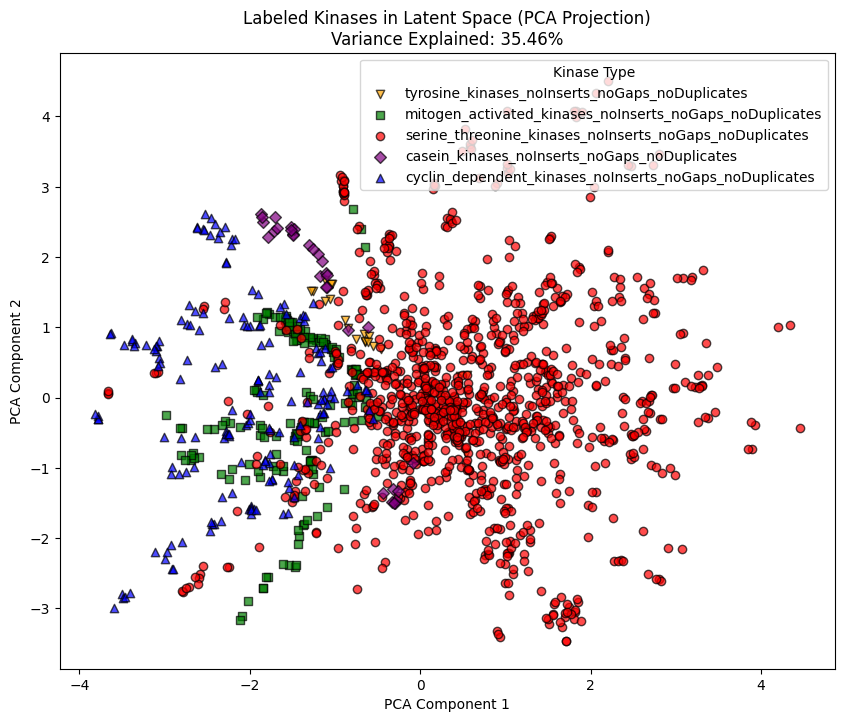

In [72]:
# Define marker and color mappings for each kinase type.
markers = {
    'serine_threonine_kinases_noInserts_noGaps_noDuplicates': 'o',
    'cyclin_dependent_kinases_noInserts_noGaps_noDuplicates': '^',
    'mitogen_activated_kinases_noInserts_noGaps_noDuplicates': 's',
    'casein_kinases_noInserts_noGaps_noDuplicates': 'D',
    'tyrosine_kinases_noInserts_noGaps_noDuplicates': 'v'
}

colors = {
    'serine_threonine_kinases_noInserts_noGaps_noDuplicates': 'red',
    'cyclin_dependent_kinases_noInserts_noGaps_noDuplicates': 'blue',
    'mitogen_activated_kinases_noInserts_noGaps_noDuplicates': 'green',
    'casein_kinases_noInserts_noGaps_noDuplicates': 'purple',
    'tyrosine_kinases_noInserts_noGaps_noDuplicates': 'orange'
}

plt.figure(figsize=(10, 8))
# Loop through each kinase type to plot them individually.
for kinase in set(labeled_labels):
    # Get indices of samples belonging to the current kinase type.
    idx = [i for i, lab in enumerate(labeled_labels) if lab == kinase]
    plt.scatter(labeled_pca[idx, 0], labeled_pca[idx, 1],
                marker=markers.get(kinase, 'o'),
                color=colors.get(kinase, 'gray'),
                edgecolor='k', alpha=0.7, 
                label=kinase)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Labeled Kinases in Latent Space (PCA Projection)\nVariance Explained: {variance_explained:.2f}%")
plt.legend(title="Kinase Type", loc="upper right")
plt.show()


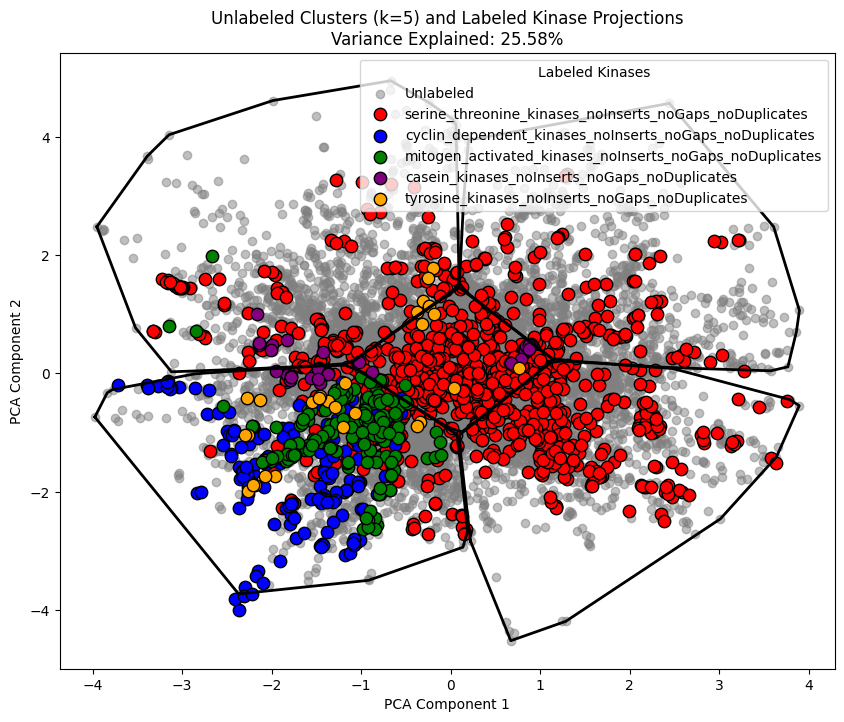

In [75]:

from scipy.spatial import ConvexHull

subset = X_val[:10000]

# Get latent representations from the VAE encoder
z_mean_unlabeled, _, _ = vae.encode(subset)
z_mean_unlabeled_np = z_mean_unlabeled.numpy() if hasattr(z_mean_unlabeled, 'numpy') else z_mean_unlabeled

# Apply PCA to reduce latent dimensions to 2
pca = PCA(n_components=2)
pca_result_unlabeled = pca.fit_transform(z_mean_unlabeled_np)

# Calculate variance explained by the first two principal components
variance_explained = np.sum(pca.explained_variance_ratio_) * 100  # percentage

# --- Clustering Unlabeled Data (loop over clusters) ---
# For demonstration, we loop over different numbers of clusters
# Here we use a single chosen cluster number to obtain boundaries; adjust as needed.
# We'll loop over k from 5 to 10 and then choose one plot; for simplicity, I'll show k=7 as an example.
chosen_k = 5
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
unlabeled_clusters = kmeans.fit_predict(pca_result_unlabeled)

# Plot the unlabeled data in gray and draw cluster boundaries
plt.figure(figsize=(10, 8))
plt.scatter(pca_result_unlabeled[:, 0], pca_result_unlabeled[:, 1], c='gray', alpha=0.5, label="Unlabeled")

# For each cluster, compute the convex hull and plot its boundary
for cluster in range(chosen_k):
    pts = pca_result_unlabeled[unlabeled_clusters == cluster]
    if pts.shape[0] >= 3:  # convex hull requires at least 3 points
        hull = ConvexHull(pts)
        # Get the convex hull vertices and close the loop by appending first point
        hull_pts = pts[hull.vertices]
        hull_pts = np.concatenate([hull_pts, hull_pts[0:1]], axis=0)
        plt.plot(hull_pts[:, 0], hull_pts[:, 1], 'k-', linewidth=2)  # boundary in black

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Unlabeled Latent Space Clusters (k={chosen_k})\nVariance Explained: {variance_explained:.2f}%")
plt.legend()

# --- Labeled Data ---
# Assuming you have the kinase_data dictionary from which we can extract labeled sequences.
# We'll combine the labeled data from different kinase types.
labeled_latents_list = []
labeled_labels = []
for kinase_type, matrix in kinase_data.items():
    matrix = matrix.astype(np.float32)
    z_mean_labeled, _, _ = vae.encode(matrix)
    z_mean_labeled_np = z_mean_labeled.numpy() if hasattr(z_mean_labeled, 'numpy') else z_mean_labeled
    labeled_latents_list.append(z_mean_labeled_np)
    # Record kinase type for each sequence in this matrix.
    labeled_labels.extend([kinase_type] * z_mean_labeled_np.shape[0])
labeled_latents = np.concatenate(labeled_latents_list, axis=0)

# Project labeled latent space using the same PCA transformation used for unlabeled data.
pca_result_labeled = pca.transform(labeled_latents)

# Define distinct colors for each kinase type (you can adjust as needed).
kinase_colors = {
    "serine_threonine_kinases_noInserts_noGaps_noDuplicates": "red",
    "cyclin_dependent_kinases_noInserts_noGaps_noDuplicates": "blue",
    "mitogen_activated_kinases_noInserts_noGaps_noDuplicates": "green",
    "casein_kinases_noInserts_noGaps_noDuplicates": "purple",
    "tyrosine_kinases_noInserts_noGaps_noDuplicates": "orange",
}

# Overlay labeled data on the same plot
for kinase, color in kinase_colors.items():
    idx = [i for i, lab in enumerate(labeled_labels) if lab == kinase]
    plt.scatter(pca_result_labeled[idx, 0], pca_result_labeled[idx, 1],
                marker='o', color=color, edgecolor='k', s=80, label=kinase)

plt.legend(title="Labeled Kinases", loc="upper right")
plt.title(f"Unlabeled Clusters (k={chosen_k}) and Labeled Kinase Projections\nVariance Explained: {variance_explained:.2f}%")
plt.show()


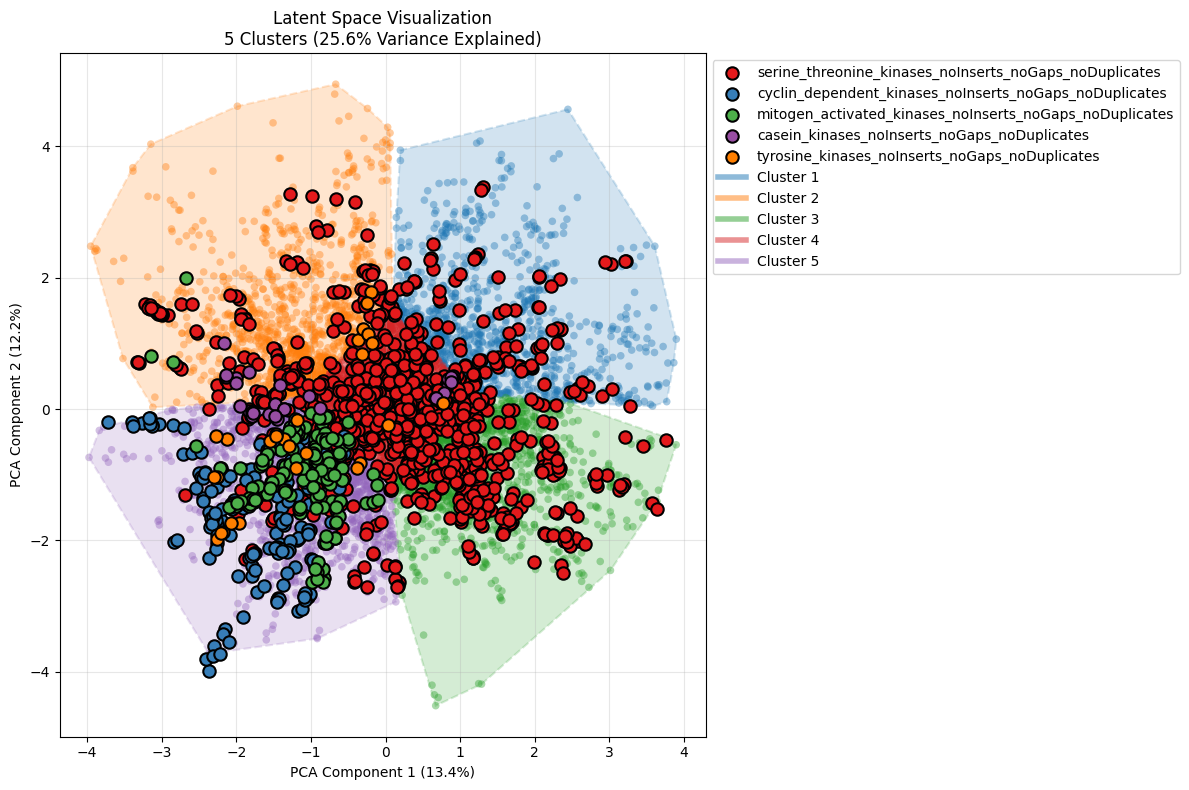

In [ ]:

# Configuration
SUBSET_SIZE = 10000
CHOSEN_K = 5  # Fixed cluster number

# Data preparation
subset = X_val[:SUBSET_SIZE]

# Latent space extraction
z_mean_unlabeled, _, _ = vae.encode(subset)
z_mean_unlabeled_np = z_mean_unlabeled.numpy() if hasattr(z_mean_unlabeled, 'numpy') else z_mean_unlabeled

# Dimensionality reduction
pca = PCA(n_components=2)
pca_result_unlabeled = pca.fit_transform(z_mean_unlabeled_np)
variance_explained = pca.explained_variance_ratio_.sum() * 100

# Clustering
kmeans = KMeans(n_clusters=CHOSEN_K, random_state=42)
unlabeled_clusters = kmeans.fit_predict(pca_result_unlabeled)

# Visualization setup
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Color configuration
cluster_cmap = plt.cm.tab10
kinase_colors = {
    "serine_threonine_kinases_noInserts_noGaps_noDuplicates": "#e41a1c",
    "cyclin_dependent_kinases_noInserts_noGaps_noDuplicates": "#377eb8",
    "mitogen_activated_kinases_noInserts_noGaps_noDuplicates": "#4daf4a",
    "casein_kinases_noInserts_noGaps_noDuplicates": "#984ea3",
    "tyrosine_kinases_noInserts_noGaps_noDuplicates": "#ff7f00",
}

# Plot unlabeled data with clusters
for cluster in range(CHOSEN_K):
    cluster_points = pca_result_unlabeled[unlabeled_clusters == cluster]
    
    # Plot points
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                color=cluster_cmap(cluster % 10), alpha=0.4, 
                s=30, edgecolors='none', label=f'_nolegend_')
    
    # Plot convex hull
    if len(cluster_points) >= 3:
        try:
            hull = ConvexHull(cluster_points)
            hull_points = np.append(hull.vertices, hull.vertices[0])
            poly = plt.Polygon(cluster_points[hull_points], 
                             alpha=0.2, color=cluster_cmap(cluster % 10),
                             linestyle='--', linewidth=1.5)
            ax.add_patch(poly)
        except:
            continue

# Process and plot labeled data
labeled_latents, kinase_labels = [], []
for kinase_type, matrix in top_5_kinase_data.items():
    matrix = matrix.astype(np.float32)
    z_mean_labeled, _, _ = vae.encode(matrix)
    z_mean_labeled_np = z_mean_labeled.numpy() if hasattr(z_mean_labeled, 'numpy') else z_mean_labeled
    labeled_latents.append(z_mean_labeled_np)
    kinase_labels.extend([kinase_type] * len(z_mean_labeled_np))

labeled_latents = np.concatenate(labeled_latents)
pca_labeled = pca.transform(labeled_latents)

# Plot labeled kinase data
for kinase, color in kinase_colors.items():
    mask = np.array(kinase_labels) == kinase
    plt.scatter(pca_labeled[mask, 0], pca_labeled[mask, 1],
               color=color, s=80, edgecolor='k', linewidth=1.5,
               marker='o', label=kinase, zorder=3)

# Legend and labels
handles, labels = plt.gca().get_legend_handles_labels()
cluster_legend = [plt.Line2D([0], [0], color=cluster_cmap(i % 10), 
                  lw=4, alpha=0.5) for i in range(CHOSEN_K)]
plt.legend(handles + cluster_legend, 
          labels + [f'Cluster {i+1}' for i in range(CHOSEN_K)],
          loc='upper left', bbox_to_anchor=(1, 1))

plt.xlabel(f"PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title(f"Latent Space Visualization\n5 Clusters ({variance_explained:.1f}% Variance Explained)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##### Top 15 kinases

In [26]:
# Prepare lists to collect latent representations and their labels.
labeled_latents = []
labeled_labels = []

# Iterate through each kinase type in your dictionary.
for kinase_type, matrix in top_15_kinase_data.items():
    # Convert data to float32 if necessary.
    matrix = matrix.astype(np.float32)
    
    # Pass the flattened matrix through the encoder.
    z_mean, _, _ = vae.encode(matrix)
    # Convert to a NumPy array (if the output is a tensor)
    z_mean_np = z_mean.numpy() if hasattr(z_mean, 'numpy') else z_mean

    # Append the latent representations and label repeated for each sample.
    labeled_latents.append(z_mean_np)
    labeled_labels.extend([kinase_type] * z_mean_np.shape[0])

# Concatenate latent vectors of all kinase types into a single array.
labeled_latents = np.concatenate(labeled_latents, axis=0)

Unlabled at latent space

In [27]:
latent_unlabeled, _, _ = vae.encode(X_val[:10000])  # shape: (10000, latent_dim)
latent_unlabeled = latent_unlabeled.numpy()

Top 15 at pca

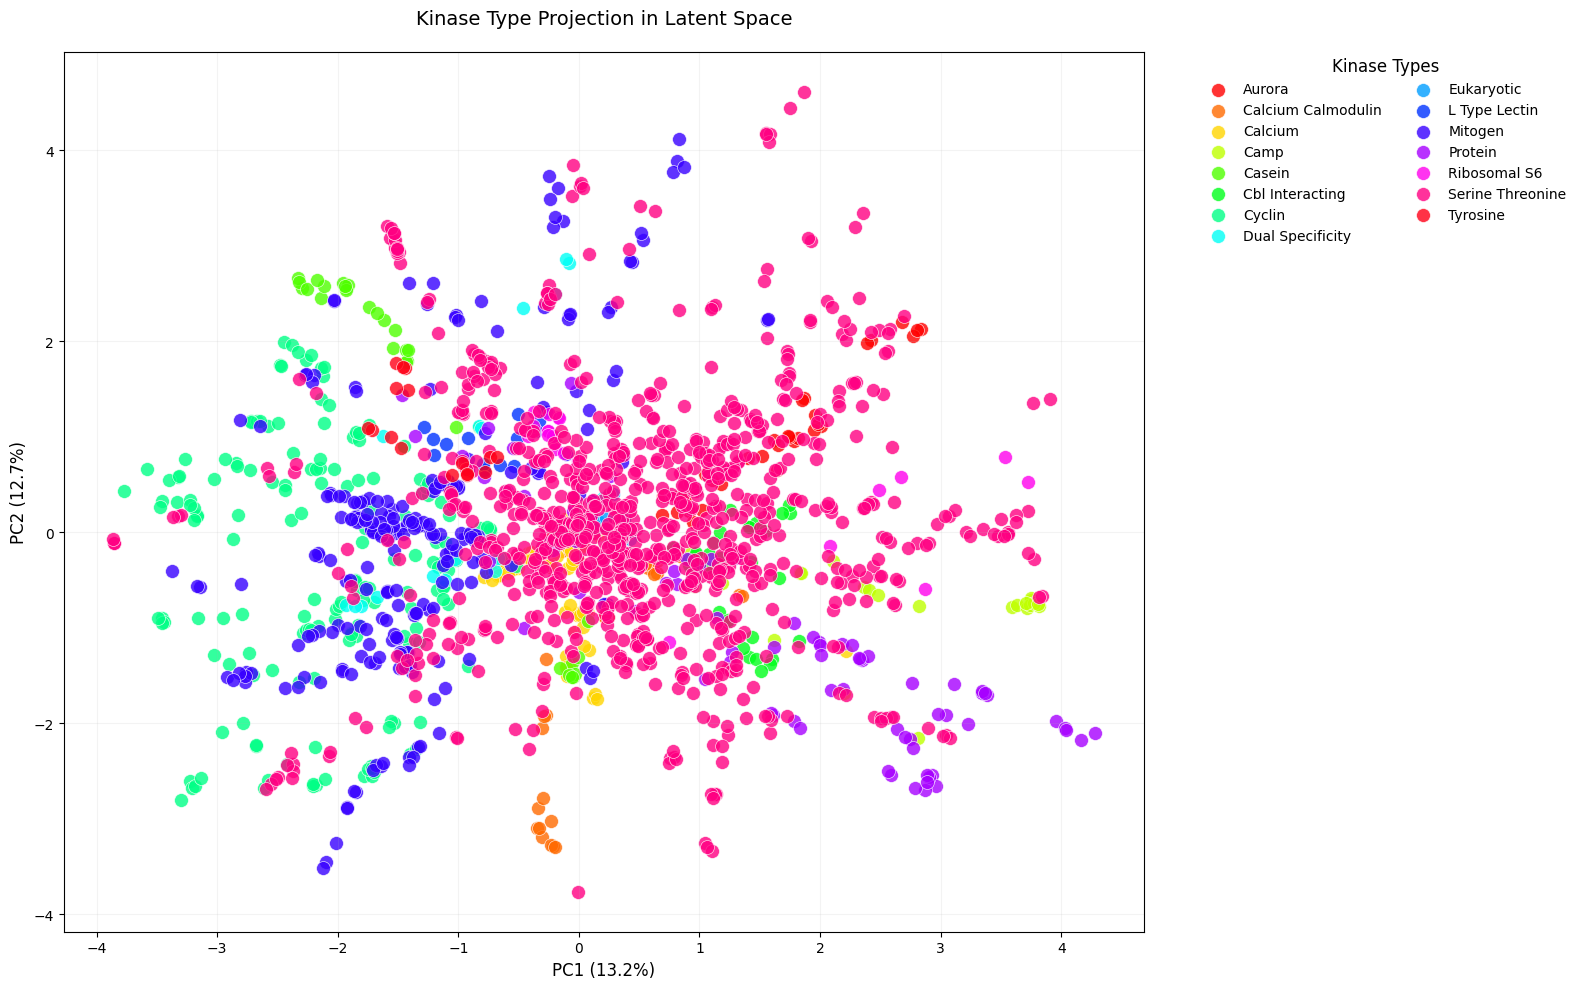

In [32]:
# Define kinase types (shortened names for readability)
kinase_types = [
    'aurora', 'calcium_calmodulin', 'calcium', 'cAMP', 'casein',
    'CBL_interacting', 'cyclin', 'dual_specificity', 'eukaryotic',
    'L_type_lectin', 'mitogen', 'protein', 'ribosomal_S6',
    'serine_threonine', 'tyrosine'
]

# Original full names mapping
full_name_mapping = {
    'aurora': 'aurora_kinases_noInserts_noGaps_noDuplicates',
    'calcium_calmodulin': 'calcium_calmodulin_dependent_kinases_noInserts_noGaps_noDuplicates',
    'calcium': 'calcium_dependent_kinases_noInserts_noGaps_noDuplicates',
    'cAMP': 'cAMP_dependent_protein_kinases_noInserts_noGaps_noDuplicates',
    'casein': 'casein_kinases_noInserts_noGaps_noDuplicates',
    'CBL_interacting': 'CBL_interacting_protein_kinases_noInserts_noGaps_noDuplicates',
    'cyclin': 'cyclin_dependent_kinases_noInserts_noGaps_noDuplicates',
    'dual_specificity': 'dual_specificity_protein_kinases_noInserts_noGaps_noDuplicates',
    'eukaryotic': 'eukaryotic_translation_initiation_factor_kinases_noInserts_noGaps_noDuplicates',
    'L_type_lectin': 'L_type_lectin_kinases_noInserts_noGaps_noDuplicates',
    'mitogen': 'mitogen_activated_kinases_noInserts_noGaps_noDuplicates',
    'protein': 'protein_kinases_noInserts_noGaps_noDuplicates',
    'ribosomal_S6': 'ribosomal_protein_S6_kinases_noInserts_noGaps_noDuplicates',
    'serine_threonine': 'serine_threonine_kinases_noInserts_noGaps_noDuplicates',
    'tyrosine': 'tyrosine_kinases_noInserts_noGaps_noDuplicates'
}

# Create vivid colors using HSV space
colors = plt.get_cmap('hsv')(np.linspace(0, 1, len(kinase_types)))


plt.figure(figsize=(16, 10))  # Larger figure size

# Plot each kinase type
for i, short_name in enumerate(kinase_types):
    full_name = full_name_mapping[short_name]
    mask = np.array([l == full_name for l in labeled_labels])
    
    plt.scatter(
        labeled_pca[mask, 0], labeled_pca[mask, 1],
        color=colors[i],
        s=100,  # Larger markers
        edgecolor='w',  # White borders for contrast
        linewidth=0.5,
        alpha=0.8,
        label=short_name.replace('_', ' ').title()  # Clean labels
    )

# Formatting
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=12)
plt.title("Kinase Type Projection in Latent Space", fontsize=14, pad=20)

# Create organized legend
legend = plt.legend(
    title="Kinase Types",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    frameon=False,
    ncol=2,  # Two columns for space efficiency
    title_fontsize=12,
    fontsize=10
)

# Add subtle grid
plt.grid(alpha=0.15)

# Adjust layout
plt.tight_layout()
plt.show()

C:\Users\sajdv\AppData\Local\Temp\ipykernel_5268\3830279988.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(full_name_mapping))


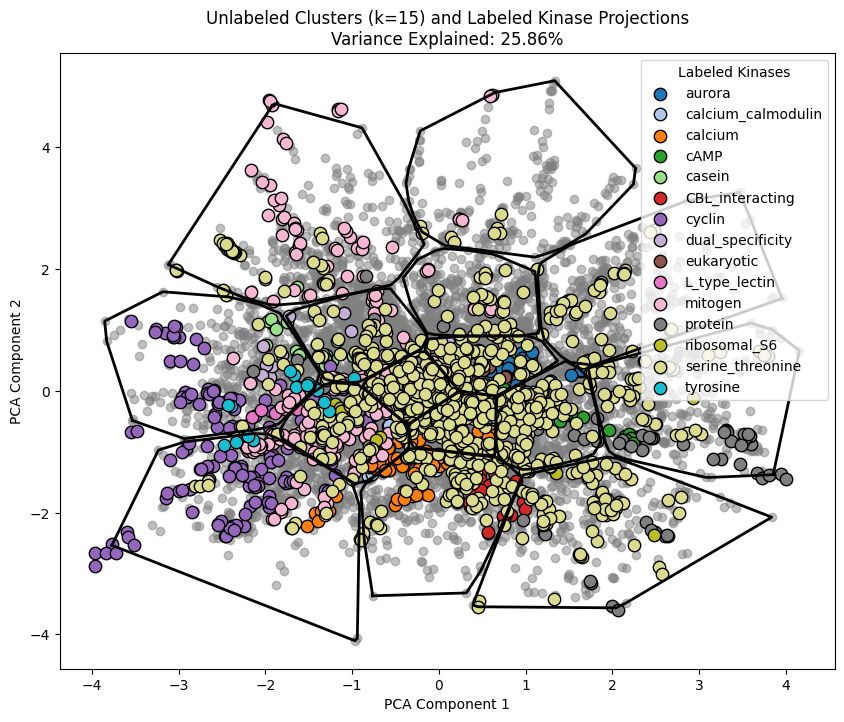

In [47]:

# Full name mapping for 15 kinase types (short: full)
full_name_mapping = {
    'aurora': 'aurora_kinases_noInserts_noGaps_noDuplicates',
    'calcium_calmodulin': 'calcium_calmodulin_dependent_kinases_noInserts_noGaps_noDuplicates',
    'calcium': 'calcium_dependent_kinases_noInserts_noGaps_noDuplicates',
    'cAMP': 'cAMP_dependent_protein_kinases_noInserts_noGaps_noDuplicates',
    'casein': 'casein_kinases_noInserts_noGaps_noDuplicates',
    'CBL_interacting': 'CBL_interacting_protein_kinases_noInserts_noGaps_noDuplicates',
    'cyclin': 'cyclin_dependent_kinases_noInserts_noGaps_noDuplicates',
    'dual_specificity': 'dual_specificity_protein_kinases_noInserts_noGaps_noDuplicates',
    'eukaryotic': 'eukaryotic_translation_initiation_factor_kinases_noInserts_noGaps_noDuplicates',
    'L_type_lectin': 'L_type_lectin_kinases_noInserts_noGaps_noDuplicates',
    'mitogen': 'mitogen_activated_kinases_noInserts_noGaps_noDuplicates',
    'protein': 'protein_kinases_noInserts_noGaps_noDuplicates',
    'ribosomal_S6': 'ribosomal_protein_S6_kinases_noInserts_noGaps_noDuplicates',
    'serine_threonine': 'serine_threonine_kinases_noInserts_noGaps_noDuplicates',
    'tyrosine': 'tyrosine_kinases_noInserts_noGaps_noDuplicates'
}

# --------------------------------------------------
# Step 1: Process Unlabeled Data and Clustering
# --------------------------------------------------

# Use a subset of the unlabeled validation data (e.g., 10,000 samples)
subset = X_val[:10000]

# Get latent representations from the VAE encoder for unlabeled data
z_mean_unlabeled, _, _ = vae.encode(subset)
z_mean_unlabeled_np = z_mean_unlabeled.numpy() if hasattr(z_mean_unlabeled, 'numpy') else z_mean_unlabeled

# Apply PCA to reduce latent dimensions to 2
pca = PCA(n_components=2)
pca_result_unlabeled = pca.fit_transform(z_mean_unlabeled_np)

# Calculate variance explained by the first two principal components
variance_explained = np.sum(pca.explained_variance_ratio_) * 100  # percentage

# Choose a clustering parameter (for example, k=5)
chosen_k = 15
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
unlabeled_clusters = kmeans.fit_predict(pca_result_unlabeled)

# Plot unlabeled data in gray and draw cluster boundaries
plt.figure(figsize=(10, 8))
plt.scatter(pca_result_unlabeled[:, 0], pca_result_unlabeled[:, 1], c='gray', alpha=0.5)

for cluster in range(chosen_k):
    pts = pca_result_unlabeled[unlabeled_clusters == cluster]
    if pts.shape[0] >= 3:  # Convex hull requires at least 3 points
        hull = ConvexHull(pts)
        hull_pts = pts[hull.vertices]
        hull_pts = np.concatenate([hull_pts, hull_pts[0:1]], axis=0)
        plt.plot(hull_pts[:, 0], hull_pts[:, 1], 'k-', linewidth=2)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Unlabeled Latent Space Clusters (k={chosen_k})\nVariance Explained: {variance_explained:.2f}%")
# (No legend for unlabeled points)

# --------------------------------------------------
# Step 2: Process Labeled Data from 15 Kinase Types
# --------------------------------------------------

labeled_latents_list = []
labeled_labels = []
for short_name, full_name in full_name_mapping.items():
    if full_name in top_15_kinase_data:
        matrix = top_15_kinase_data[full_name].astype(np.float32)
        z_mean_labeled, _, _ = vae.encode(matrix)
        z_mean_labeled_np = z_mean_labeled.numpy() if hasattr(z_mean_labeled, 'numpy') else z_mean_labeled
        labeled_latents_list.append(z_mean_labeled_np)
        # Record the full_name as the label (we'll map it back to the short name later)
        labeled_labels.extend([full_name] * z_mean_labeled_np.shape[0])
labeled_latents = np.concatenate(labeled_latents_list, axis=0)

# Project labeled latent space using the same PCA transformation
pca_result_labeled = pca.transform(labeled_latents)

# --------------------------------------------------
# Step 3: Define Distinct Colors Using Short Names
# --------------------------------------------------

# Create a colormap with 15 distinct colors (using e.g., tab20)
cmap = plt.cm.get_cmap('tab20', len(full_name_mapping))
# Build a dictionary keyed by the short name
kinase_colors = {short: plt.cm.tab20(i/15) for i, short in enumerate(full_name_mapping.keys())}


# --------------------------------------------------
# Step 4: Overlay Labeled Data and Add Legend with Short Names
# --------------------------------------------------

# Overlay colored points for each kinase type using short name for legend labels
for short_name, full_name in full_name_mapping.items():
    idx = [i for i, lab in enumerate(labeled_labels) if lab == full_name]
    # Plot with legend label as the short name
    plt.scatter(pca_result_labeled[idx, 0], pca_result_labeled[idx, 1],
                marker='o', color=kinase_colors[short_name], edgecolor='k', s=80, label=short_name)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Unlabeled Clusters (k={chosen_k}) and Labeled Kinase Projections\nVariance Explained: {variance_explained:.2f}%")
plt.legend(title="Labeled Kinases", loc="upper right")
plt.show()


##### we need to Augment the Labeled Data => do it later

In [ ]:

def augment_class(latent_vectors, n_samples=50, scale=0.1):
    # Compute the centroid of the latent vectors for a specific class.
    centroid = np.mean(latent_vectors, axis=0)
    # Create synthetic samples by perturbing the centroid.
    synthetic_latents = centroid + np.random.normal(scale=scale, size=(n_samples, latent_vectors.shape[1]))
    return synthetic_latents

# Example for augmenting one kinase type:
# Assume you want to augment the casein kinase class.
casein_idx = [i for i, lab in enumerate(labeled_labels) if lab == 'casein_kinases_noInserts_noGaps_noDuplicates']
latent_casein = labeled_latents[casein_idx]
synthetic_casein = augment_class(latent_casein, n_samples=100)

# You can decode these synthetic latent vectors if you wish:
synthetic_sequences = vae.decode(synthetic_casein).numpy()

# And then re-encode if needed to obtain the latent representations:
latent_synthetic, _, _ = vae.encode(synthetic_sequences)
latent_synthetic_np = latent_synthetic.numpy() if hasattr(latent_synthetic, 'numpy') else latent_synthetic

# Add these augmented points to your visualization.
latent_augmented = np.concatenate([labeled_latents, latent_synthetic_np], axis=0)
# (Also update labels accordingly before applying PCA and plotting.)


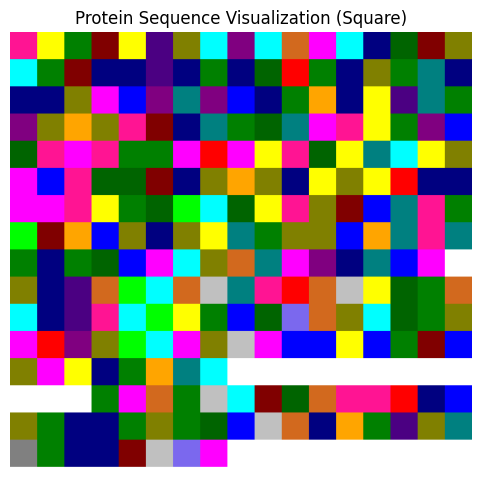

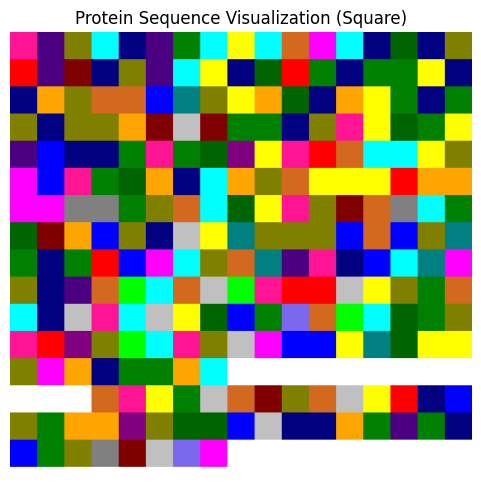

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, sqrt

def sequence_to_square_image(seq, scale=20, pad_color=(255, 255, 255)):
    """
    Given a protein sequence (e.g., 263 amino acids), 
    creates a square image by rearranging the sequence as a grid.
    
    Parameters:
        seq (str): The protein sequence (including '-' for gaps).
        scale (int): Scale factor for enlarging each pixel.
        pad_color (tuple): RGB color used for padding (default white).
        
    Returns:
        Displays the square image.
    """
    L = len(seq)
    # Calculate the smallest square side length that can fit L characters.
    n = int(ceil(sqrt(L)))
    total_pixels = n * n

    # Define the color mapping. Adjust colors as desired.
    color_mapping = {
        '-': (255, 255, 255),  # gap: white
        'A': (255, 0, 0),       # red
        'C': (0, 255, 0),       # green
        'D': (0, 0, 255),       # blue
        'E': (255, 255, 0),     # yellow
        'F': (255, 0, 255),     # magenta
        'G': (0, 255, 255),     # cyan
        'H': (128, 0, 0),       # maroon
        'I': (0, 128, 0),       # dark green
        'K': (0, 0, 128),       # navy
        'L': (128, 128, 0),     # olive
        'M': (128, 0, 128),     # purple
        'N': (0, 128, 128),     # teal
        'P': (192, 192, 192),   # silver
        'Q': (128, 128, 128),   # gray
        'R': (255, 165, 0),     # orange
        'S': (210, 105, 30),    # chocolate
        'T': (75, 0, 130),      # indigo
        'V': (0, 100, 0),       # dark green (different from I)
        'W': (123, 104, 238),   # medium slate blue
        'Y': (255, 20, 147)     # deep pink
    }
    
    # Create a list of colors for each amino acid in the sequence.
    colors_list = [color_mapping.get(aa, (0, 0, 0)) for aa in seq]
    
    # Pad the list if necessary
    if L < total_pixels:
        pad_pixels = total_pixels - L
        colors_list.extend([pad_color] * pad_pixels)
    
    # Convert to numpy array and reshape to square form
    img_array = np.array(colors_list, dtype=np.uint8).reshape(n, n, 3)
    
    # Scale the image up by repeating each pixel 'scale' times in both dimensions.
    img_scaled = np.repeat(np.repeat(img_array, scale, axis=0), scale, axis=1)
    
    # Display the image using matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(img_scaled)
    plt.axis('off')
    plt.title("Protein Sequence Visualization (Square)")
    plt.show()

# Example usage:
# Make sure your sample sequence has exactly 263 characters. Adjust as necessary.
sample_seq = "YEIHETLGMGSFGKVHLGIHKKTKIKVAIKLINKKKLFDMNMDKIRKETNIMLRLYHKNIVNFYEIMDVYFYIIFAFEYVENGELFDYVVHKLRLKELEAKKFFYEIVCGVEYLHDNYICHRDLKLENILLDRNYNIKIVDFGLSNFMKNDF-LKTSCGSPNYASPEVISGKTYGCEIDVWSLGVILFAMLCGFLPFDDEDIHDLFEKIRNG------------IFSIPGHVSYYAKDLIKKILIVDPSKRITLNQIKKHPWF"

sequence_to_square_image(sample_seq, scale=20)

a ="YTLGKTIGEGSFGKVKLATHKLTGEKVAIKIIEKKRLSSDNLERVKREIKILKLLRHPHIIKLYEVIETDKKIYIVMEYASGGELFDYIVRKGRLSEEEARRFFQQILSGVEYLHSQGIVHRDLKPENLLLDSDLNIKIADFGLSNTYKDGNFLKTSCGSPCYAAPELISGKPYGPEVDIWSCGVILYAMLCGYLPFDDENVEELFRKIIRG------------SYEIPSHLSPEAKDLIRRMLVVDPKKRITIKDILQHPWF"
sequence_to_square_image(a,scale=20)

